In [8]:
%pylab inline
import numpy as np
import sys
from sklearn.neighbors import KernelDensity
from tqdm import tqdm

import sys
sys.path.append('../../core/')
from utils import *

Populating the interactive namespace from numpy and matplotlib


In [36]:
@nb.njit
def D_l1_log(p1,p2,r1,r2,x):
    """
    Expected difference between log-pdfs on the intersection of their supports
    divided by size of intersection.
    """
    
    dx = x[1]-x[0]  
    D = 0
    W = 0
    
    for j in range(len(x)):
        if x[j]>r1[0] and x[j]>r2[0] and x[j]<r1[1] and x[j]<r2[1]:
            D = D+np.abs(np.log(p1[j])-np.log(p2[j]))*dx
            W = W+dx
    
    return D/W**2

In [37]:
loss_types = ['MSE', 'RE', 'OW','AOW']
taus = [2.0,4.0,6.0,8.0,10.0]
n_restarts = 20
path = '../../saved_results/kol/'

In [38]:
if False:
    
    Results = {}

    for loss_type in loss_types:
        for tau in taus:

            filename = path + 'results_loss_'+loss_type+'_tau'+str(tau)+'.npy'
            Results[loss_type, tau] = np.load(filename, allow_pickle=True).item()

            Results[loss_type,tau]['NN_mean'] = np.mean(np.vstack([Results[loss_type, tau]['NN_'+str(j+1)] 
                                                         for j in range(n_restarts)]), axis=0)

            Results[loss_type,tau]['error'] = np.vstack([Results[loss_type, tau]['true'].flatten()-
                                                         Results[loss_type, tau]['NN_'+str(j+1)]
                                                         for j in range(n_restarts)])

    m = len(Results[loss_types[0],tau]['true'])
    m_tv = int(0.6*len(Results[loss_types[0],tau]['true']))

    # Compute KDE estimates
    kde_estimates = {}

    c = np.linspace(-3,9.5,200)
    kde_estimates['c'] = c
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1)
    sample_rate = 1

    true = Results[loss_types[0],tau]['true'][m_tv:].reshape(-1,1)[::sample_rate]
    kde.fit(true)
    kde_estimates['true'] = [np.exp(kde.score_samples(c.reshape(-1,1)))]
    kde_estimates['true'].append([np.min(true), np.max(true)])

    for loss_type in loss_types:
        for tau in taus:
            kde_estimates[loss_type,tau] = [[],[]]
            for ind in tqdm(range(n_restarts)):
                pred = Results[loss_type,tau]['NN_'+str(ind+1)][m_tv:].reshape(-1,1)[::sample_rate]
                kde.fit(pred)
                kde_estimates[loss_type,tau][0].append(np.exp(kde.score_samples(c.reshape(-1,1))))
                kde_estimates[loss_type,tau][1].append([np.min(pred), np.max(pred)])
    
    np.save(path + 'kde_estimates', kde_estimates)
    
else:
    kde_estimates = np.load(path + 'kde_estimates.npy', \
                            allow_pickle=True).item()
    c = kde_estimates['c']

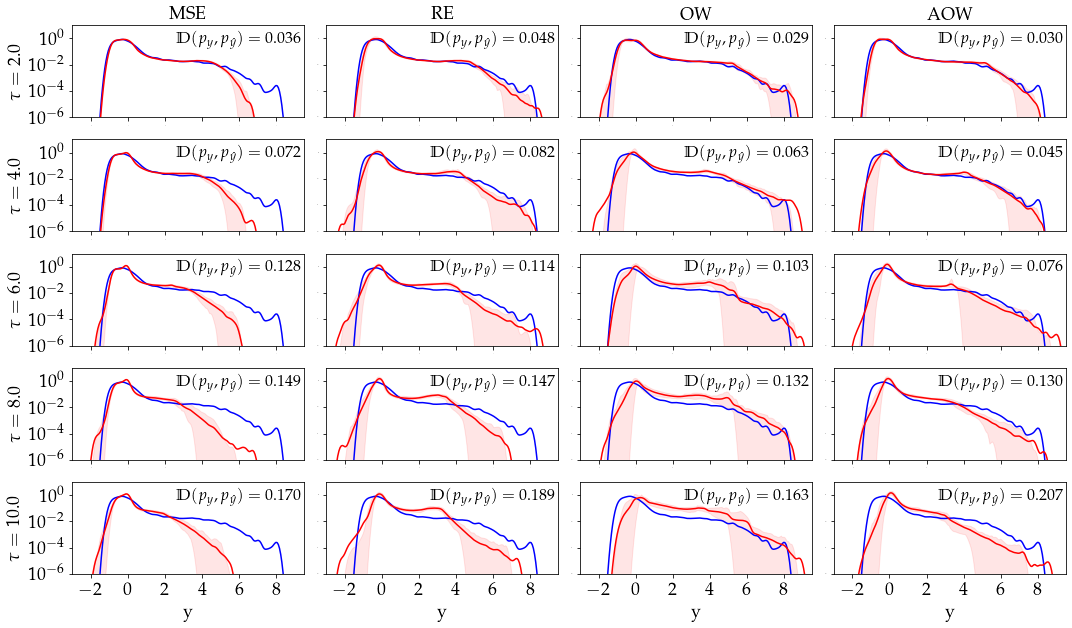

In [40]:
figure(figsize = (15,5*len(taus)/3+0.5))
label_fs = 18
alpha = 0.1
pct = 10

for i in range(len(taus)):
    for j in range(len(loss_types)):

        ax=subplot(len(taus),4,4*i+j+1)

        plot(c, kde_estimates['true'][0], 'b', label='True')
        kde_pred = kde_estimates[loss_types[j],taus[i]][0]
        plot(c, np.mean(kde_pred,axis=0), 'r', label=loss_types[j])
        fill_between(c, 
                     np.percentile(kde_pred,pct,axis=0),
                     np.percentile(kde_pred,100-pct,axis=0), color='r', alpha=alpha)
        
        yscale('log')
        ylim([1e-6,10])
        xlim([np.min(c), np.max(c)])
        xlim([-3, 9.5])

        if i==len(taus)-1:
            xlabel('y', fontsize = label_fs)
            xticks(fontsize = label_fs)
        else:
            xticks(fontsize=0)
            
        if i==0:
            title(loss_types[j], fontsize = label_fs)

        if j==0:
            ylabel(r'$\tau='+str(taus[i])+'$', fontsize = label_fs)
            yticks(fontsize = label_fs)
        else:
            yticks(fontsize=0)

        true = kde_estimates['true'][0]
        range_true = np.array(kde_estimates['true'][1])
        preds = kde_estimates[loss_types[j],taus[i]][0]
        range_preds = kde_estimates[loss_types[j],taus[i]][1]
        d = np.mean([D_l1_log(true,pred,range_true,np.array(range_pred),c) 
                     for pred, range_pred in zip(preds, range_preds)],axis=0)
        
        text(0.99, 0.95, r'$\mathbb{D}(p_y, p_{\hat{y}})= %5.3f$'% d,
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes,
            color='k', fontsize=label_fs-2)

tight_layout()